# Quality Control for Fitting Results

This notebook performs quality control by searching for extreme outliers among the fit results in terms of fit flux and SNR and flagging. It also checks fitted line profiles against spectra of nearby cluster members: if a similar line can be fitted to the cluster member spectrum (i.e. a significant fit is obtained with the same central velocity), then the line is considered a contaminant and is flagged with the flag 'c'.

In [1]:
import numpy as np
from astropy.io import fits
import astropy.table as aptb
import matplotlib.pyplot as plt
from matplotlib import patches
from pathlib import Path

from scipy.optimize import curve_fit
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib.colors import PowerNorm
import gc
from astropy.table import Column

from astro_utils import io as auio
from astro_utils import quality_control as auqc

No Bottleneck unit testing available.


/home/james/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/james/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
# Load the megatable
SPEC_SOURCE = 'APER' # can be 'aper', 'R21', etc
SPEC_TYPE = '1fwhm_opt' # can be '1fwhm', '2fwhm_opt', etc for APER, 'weight_skysub' etc for R21

megatab, checkpoint = auio.load_flagged_megatab(f"./megatables/lae_megatab_{SPEC_TYPE}.fits")

Loading megatable from base file: ./megatables/lae_megatab_1fwhm_opt.fits


In [3]:
# Calculate Lyman alpha RCHSQ as this wasn't done in the original fitting routine
from astro_utils import lya_fitting as aulyafit

if 'RCHSQ' not in megatab.colnames:
    aulyafit.calculate_lya_rchsq(megatab, spec_source=SPEC_SOURCE, spec_type=SPEC_TYPE, modify_inplace=True)

Loading aperture spectrum for MACS0940 object P318...
Loading aperture spectrum for MACS1206 object P2684...
Loading aperture spectrum for MACS1206 object P2603...
Loading aperture spectrum for A2744 object P3065...
Loading aperture spectrum for MACS0940 object P183...
Loading aperture spectrum for MACS0940 object M146...
Loading aperture spectrum for SMACS2131 object M126...
Loading aperture spectrum for RXJ1347 object M861...
Loading aperture spectrum for MACS1206 object X1...
Loading aperture spectrum for MACS0416NE object P159...
Loading aperture spectrum for SMACS2131 object X3...
Loading aperture spectrum for MACS1206 object P3432...
Loading aperture spectrum for RXJ1347 object M954...
Loading aperture spectrum for RXJ1347 object P2780...
Loading aperture spectrum for MACS2214 object P443...
Loading aperture spectrum for MACS0257 object M81...
Loading aperture spectrum for A370 object M1592...
Loading aperture spectrum for RXJ1347 object X2...
Loading aperture spectrum for RXJ134

In [ ]:
# First calculate the LOF scores based on the provided features.
# We will use the results of this step to determine an appropriate threshold for QC.
qc_features=['FWHMR', 'ASYMR', 'CONT', 'RCHSQ', 'SNRR']
lof_scores = auqc.get_lof_score(megatab, qc_features, nan_policy='remove', n_neighbors=20, snr_cap=50, rchsq_cap=5)

print(f"LOF scores computed for {len(lof_scores)} sources.")
print(f"  - {np.sum(np.isnan(lof_scores))} sources have NaN LOF scores and will be removed.")
print(f"\nNo auto-flagging applied. Inspect LOF score distribution to choose threshold.")

Imputing 2 high-SNR, high-χ² sources to median values for outlier detection.
LOF scores computed for 951 sources.
  - 2 high-SNR, high-χ² sources imputed for detection
  - 0 sources have NaN values and will be auto-flagged

No auto-flagging applied. Inspect LOF score distribution to choose threshold.


  Max: 6.025
  99th percentile: 2.259
  95th percentile: 1.572
  Median: 1.064
  Min: 0.959

LOF Score Statistics:


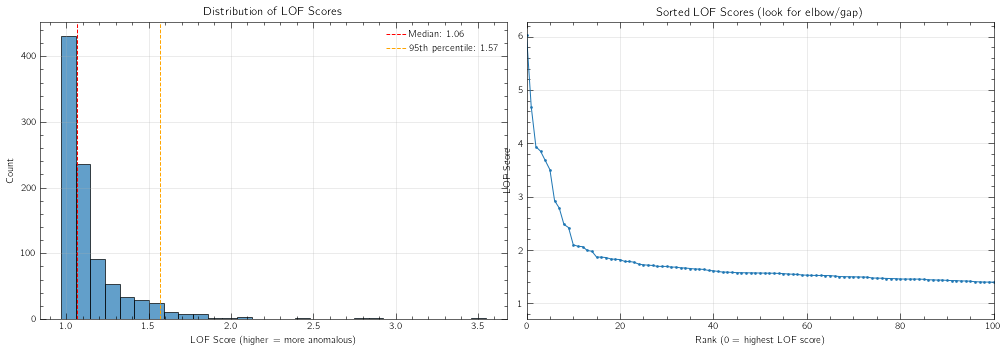

In [8]:
# Plot LOF score distribution to help choose threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
valid_scores = qc_report['lof_scores'][~np.isnan(qc_report['lof_scores'])]
bins = np.linspace(np.percentile(valid_scores, 1), np.percentile(valid_scores, 99.5), 30)
ax1.hist(valid_scores, bins=bins, alpha=0.7, edgecolor='black')
ax1.axvline(np.median(valid_scores), color='red', linestyle='--', label=f'Median: {np.median(valid_scores):.2f}')
ax1.axvline(np.percentile(valid_scores, 95), color='orange', linestyle='--', label=f'95th percentile: {np.percentile(valid_scores, 95):.2f}')

ax1.set_xlabel('LOF Score (higher = more anomalous)')
print(f"  Max: {np.max(valid_scores):.3f}")

ax1.set_ylabel('Count')
print(f"  99th percentile: {np.percentile(valid_scores, 99):.3f}")

ax1.set_title('Distribution of LOF Scores')
print(f"  95th percentile: {np.percentile(valid_scores, 95):.3f}")

ax1.legend()
print(f"  Median: {np.median(valid_scores):.3f}")
ax1.grid(alpha=0.3)
print(f"  Min: {np.min(valid_scores):.3f}")

print(f"\nLOF Score Statistics:")

# Sorted LOF scores to identify "elbow"

sorted_scores = np.sort(valid_scores)[::-1]

ax2.plot(sorted_scores, 'o-', markersize=2)
plt.tight_layout()
ax2.set_xlabel('Rank (0 = highest LOF score)')

ax2.set_ylabel('LOF Score')
ax2.set_xlim(0, min(100, len(sorted_scores)))

ax2.set_title('Sorted LOF Scores (look for elbow/gap)')
ax2.grid(alpha=0.3)

plt.show()

In [10]:
# Show top 50 sources ranked by LOF score for manual inspection
n_show = 50
sorted_indices = np.argsort(qc_report['lof_scores'])[::-1]  # Sort descending
top_indices = sorted_indices[:n_show]

print(f"\n{'='*80}")
print(f"Top {n_show} sources by LOF score (candidates for flagging):")
print(f"{'='*80}\n")
print(f"{'Rank':<6} {'Cluster':<8} {'ID':<8} {'LOF':<8} {'SNRR':<8} {'RCHSQ':<8} {'FWHMR':<8} {'ASYMR':<8} {'CONT':<8}")
print(f"{'-'*80}")

for rank, idx in enumerate(top_indices, 1):
    if np.isnan(qc_report['lof_scores'][idx]):
        continue
    row = megatab[idx]
    print(f"{rank:<6} {row['CLUSTER']:<8} {row['iden']:<8} "
          f"{qc_report['lof_scores'][idx]:<8.3f} "
          f"{row['SNRR']:<8.2f} "
          f"{row['RCHSQ']:<8.2f} "
          f"{row['FWHMR']:<8.2f} "

          f"{row['ASYMR']:<8.3f} "

          f"{row['CONT']:<8.2f}")
    print(f"{'='*80}")
    print(f"Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.")

print(f"Based on the distribution and these top sources, choose a LOF threshold.")
print(f"\n{'='*80}")


Top 50 sources by LOF score (candidates for flagging):

Rank   Cluster  ID       LOF      SNRR     RCHSQ    FWHMR    ASYMR    CONT    
--------------------------------------------------------------------------------
1      SMACS2031 M78      6.025    18.99    5.85     10.94    -0.147   658.20  
Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.
2      RXJ1347  X8       4.687    18.43    2.71     5.12     0.029    472.03  
Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.
3      SMACS2031 P74      3.936    160.65   6.10     4.89     0.203    34.05   
Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.
4      A370     M1335    3.851    9.56     6.25     14.17    0.103    366.31  
Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.
5      MACS0329 M850     3.680    7.46     5.93     12.23    0.232    42.43   
Then re-run megatable_qc with lof_threshold=<your_value> to apply flagging.
6     

In [ ]:
#little function that helps with setting bounds:
def bound(sign):
    if sign == +1:
        return 0., inf
    if sign == -1:
        return -inf, 0.

In [ ]:
def estimate_n(z):
    if z < 0.01:
        return 0.5
    else:
        return 2.0

In [ ]:
# 
skiplist = []

In [ ]:
megatab_interest = megatab

# Parameters for finding contaminants
maxdist = 10 # Max distance to search for contaminants (arcsec)
imgbuff = 1  # Extra buffer around image (arcsec)
bbcenter = 7000 # Center of pseudo-broadband filter (Angstrom)
bbrange = 100   # Half-width of pseudo-broadband filter (Angstrom)
maskrad = 1     # Mask radius around contaminant (arcsec)

for i, row in enumerate(megatab_interest):
    if f"{row['CLUSTER']}.{row['iden']}" in skiplist:
        continue
#     if f"{row['CLUSTER']}.{row['iden']}" != 'A370.4':
#         continue
    if i <= checkpoint:
        continue
    print(f"Searching for possible contaminants for {row['CLUSTER']} object {row['iden']}.")
    ccmems = auqc.find_closest_cluster_member(row, maxdist = maxdist * u.arcsec, return_all = True)
    print(f"Found {len(ccmems)} candidates.")
    if not ccmems:
        print(f"No potential contaminants within {maxdist} arcseconds! Moving to next object.")
        continue
    ccmem = ccmems[0]
    print(f"Found closest source at z = {ccmem['z']:.3f}")
    fig, axs = plt.subplots(1,2,figsize = (11,4), facecolor='w')
    ax = axs[0]
    whtimg = mf.make_muse_img(row, 2 * (maxdist + imgbuff), bbcenter, bbrange)
    #add brightnesses based on our pseudo-broadband image:
    normdists = []
    brightsnrs = []
    for crow in ccmems:
        galaxy_ra = crow['RA']
        galaxy_dec = crow['DEC']
        galaxy_z = crow['z']
        cpos = SkyCoord(galaxy_ra, galaxy_dec, unit='deg')
        cimpos = cpos.to_pixel(WCS(whtimg.wcs.to_header()))
        ax.scatter(*cimpos, s=90, color = 'gray', marker='X')
        cimcirc = mf.create_circular_mask(whtimg.data, cimpos[::-1], maskrad / 0.2)
        distance = np.sqrt((row['RA'] - galaxy_ra)**2 + (row['DEC'] - galaxy_dec)**2) * 3600.
        apsum = np.abs(np.nansum(whtimg.data.data[cimcirc]))
        aperr = np.sqrt(np.nansum(whtimg.var.data[cimcirc]))
        apsnr = apsum / aperr
        brightsnrs.append(apsnr)
        if distance <= mf.get_fwhm(row['CLUSTER']) and apsnr > 10.:
            normdists.append(-1. / np.sqrt(apsum))
        else:
            normdists.append(distance / np.sqrt(apsum))
    ccmems.add_column(Column(normdists, name='BRIGHTDIST'))
    ccmems.add_column(Column(brightsnrs, name='BRIGHTSNR'))
    ccmems.sort(keys='BRIGHTDIST', reverse=False)
    ccmem = ccmems[0]
    for mem in ccmems[1:]:
        distance = np.sqrt((ccmem['RA'] - mem['RA'])**2 + (ccmem['DEC'] - mem['DEC'])**2) * 3600.
        if distance > 1.1 * maskrad and mem['BRIGHTSNR'] > 10.0:
            whtimg.mask_region((mem['DEC'], mem['RA']), maskrad)
    if ccmem['BRIGHTDIST'] < 0.:
        print(f"WARNING! BRIGHT FOREGROUND OBJECT UNRESOLVED FROM TARGET. SPECTRAL SEPARATION MAY FAIL.")
    whtimg_shp = np.shape(whtimg.data)
    bbimg = ax.imshow(whtimg.data, norm = PowerNorm(0.5, vmin=0, vmax=mf.get_centmax(whtimg.data, 20.)))
    ccmem_pos = SkyCoord(ccmem['RA'], ccmem['DEC'], unit='deg')
    ccmem_impos = ccmem_pos.to_pixel(WCS(whtimg.wcs.to_header()))
    ax.scatter(*ccmem_impos, s=360, color = 'red', marker='+')
    ccmem_impos_int = (int(ccmem_impos[1]), int(ccmem_impos[0]))
    rough_rad = np.nanmax([np.sqrt(ccmem['ISOAREAF_IMAGE'] / np.pi), 1.0])
    sersic_bounds = {
        'n': (1.0, 4.0),
        'ellip': (0, 0.2),
#         'amplitude': (1.0, 1e6),
        'theta': (-np.pi, np.pi),
        'r_eff': (0.1, 2 * rough_rad)
    }
    sersic_fixed = {
        'n': False,
        'x_0': True,
        'y_0': True,
        'amplitude': True,
#         'ellip': True,
#         'theta': True
    }
    if ccmem['z'] < 0.01:
        sersic_fixed['n'] = True
        sersic_fixed['amplitude'] = False
    initial_gs = {
        'r_eff': rough_rad,
#         'amplitude': np.abs(whtimg.data[ccmem_impos_int]),
        'amplitude': 1.0,
        'theta': 0.0,
        'ellip': 0.0,
        'n': estimate_n(ccmem['z'])
    }
    print(f"Fitting profile to the most likely contaminant...")
    sersic = mf.fit_sersic(whtimg.data, ~whtimg.mask, ccmem_impos, initial_gs['amplitude'], initial_gs['r_eff'], 
                           initial_gs['theta'], initial_gs['ellip'], initial_gs['n'], bounds=sersic_bounds, 
                           floor=False, fixed = sersic_fixed, add_core=False)
    print(f"Fitted the following profile:\n")
    for k, par in enumerate(sersic.param_names):
        print(f"{par} \t {sersic.parameters[k]}")
    y, x = np.mgrid[:np.shape(whtimg.data)[0], :np.shape(whtimg.data)[1]]
    modimg = axs[1].imshow(whtimg.data.data - sersic(x, y), 
                           norm = PowerNorm(0.5, vmin = ax.get_images()[0].get_clim()[0], vmax = ax.get_images()[0].get_clim()[1]))
    cbars = [mf.sensible_colorbar(fig, a, a.get_images()[0]) for a in axs]
    ticks = mf.gen_img_ticks(whtimg, 0.2, tickspace=3.0)
    for n, a in enumerate(axs):
        a.set_yticks(ticks[1])
        a.set_xticks(ticks[0])
        a.set_yticklabels(ticks[3])
        a.set_xticklabels(ticks[2])
        a.set_xlabel(r"$ \upDelta $R.A. ($''$)")
        a.set_ylabel(r"$ \upDelta $Dec ($''$)")
        cbars[n].set_label(r"Flux density ($10^{-20}$\,erg\,s$^{-1}$\,cm$^{-2}$\,\AA$^{-1}$)")
        circ = patches.Circle((np.shape(whtimg.data)[0]/2., np.shape(whtimg.data)[1]/2.),
                               radius=mf.get_fwhm(row['CLUSTER'])/0.2, facecolor='none', edgecolor='coral', linestyle='--')
        a.add_artist(circ)
    ax.set_title(f"{row['CLUSTER']} source {'X' if row['idfrom'][0] == 'E' else row['idfrom'][0]}{row['iden']}")
    fig.savefig(f"../plots/{row['CLUSTER']}/{row['idfrom'][0]}{row['iden']}_sersic_sub.pdf", bbox_inches='tight')
    plt.show()
    plt.close()
    #we now need to sum the sersic profile over the aperture containing the target
    targimpos = SkyCoord(row['RA'], row['DEC'], unit='deg').to_pixel(WCS(whtimg.wcs.to_header()))
    mod_apersum = np.ma.sum(
        np.ma.masked_array(
            data=sersic(x, y),
            mask=~mf.create_circular_mask(
                sersic(x, y), (targimpos[1], targimpos[0]), mf.get_fwhm(row['CLUSTER']) / 0.2
            )
        )
    )
    ccmem_spec = mf.load_r21_spec(row['CLUSTER'], ccmem['iden'], ccmem['idfrom'], spectype='noweight_skysub')
    #normalise by the model flux:
    normrange = np.logical_and(bbcenter - bbrange < ccmem_spec['wavelength'], ccmem_spec['wavelength'] < bbcenter + bbrange)
    ccmem_spec['spec'] /= np.nanmean(ccmem_spec['spec'][normrange])
    ccmem_spec['spec'] *= mod_apersum
    fig, ax = plt.subplots(figsize = (24,4), facecolor='w')
    ax.step(ccmem_spec['wavelength'], ccmem_spec['spec'], where='mid')
    ax.errorbar(ccmem_spec['wavelength'], ccmem_spec['spec'], 
                yerr = 0., linestyle='', color='gray',
               capsize=0.)
    ax.set_xlabel(r"Wavelength ($\AA$)")
    ax.set_ylabel(r"Flux density ($10^{-20}$\,erg\,s$^{-1}$\,cm$^{-2}$\,\AA$^{-1}$)")
    ax.set_title(f"Possible contaminant spectrum (ID: {ccmem['idfrom'][0]}{ccmem['iden']})")
    plt.show()
    plt.close()
    print(f"Attempting to match lines in target spectrum with contaminant...")
    fig = plt.figure(figsize=(13,30), facecolor='w')
    counter = 0
    for col in row.colnames:
        if 'SNR_' not in col:
            continue
        if not np.abs(row[col]) > 3.0:
            continue
        lname = col.split('_')[1]
        print(f"Checking the {lname} line...")
        fitprops = {
            'LPEAK': 0.,
            'FWHM': 0.,
            'FLUX': 0.,
            'SNR': 0.,
            'CONT': 0.,
            'SLOPE': 0.
        }
        for p in fitprops.keys():
            fitprops[p] = row[f"{p}_{lname}"]
        sign = np.sign(fitprops['SNR'])
        linereg = np.logical_and(fitprops['LPEAK'] - 100 < ccmem_spec['wavelength'], 
                                 ccmem_spec['wavelength'] < fitprops['LPEAK'] + 100)
        axnew = fig.add_subplot(10,5,counter+1)
        counter += 1
        ccmem_wl = ccmem_spec['wavelength'][linereg]
        ccmem_flux = ccmem_spec['spec'][linereg]
        ccmem_specerr = ccmem_spec['error'][linereg]
        targspec = mf.plotline(row['iden'], row['CLUSTER'], fitprops['LPEAK'], axnew, spec_source = 'R21', plot_cluslines=False,
                       plot_bkg=False, plot_sky=False, plot_clusspec=False, normalise=False, label='putative '+lname,
                       model = [mf.gauss, fitprops['FLUX'], fitprops['LPEAK'], fitprops['FWHM'], fitprops['CONT'], fitprops['SLOPE']],
                       return_spectrum = True)
        ccmem_specerr = targspec['spec_err']
        axnew.step(ccmem_wl, ccmem_flux, alpha=0.7, where='mid', color='teal', label='contaminant spectrum')
        axnew.errorbar(ccmem_wl, ccmem_flux, alpha=0.5, yerr = ccmem_specerr, color='teal')
        if np.nanmax(ccmem_flux / ccmem_specerr) < 3.0:
            print(f"Contaminant spectrum is insignificant, skipping fit.")
            continue
        #now fit a similar model (same lpeak) to the contaminant spectrum:
        local_median = np.nanmedian(ccmem_flux)
        targz = row['z']
        velaxis = mf.wave2vel(ccmem_wl, fitprops['LPEAK'] / (1 + targz), z=targz)
        fit_reg = np.logical_and(-2000. < velaxis, velaxis < 2000.) * (~np.isnan(ccmem_flux)) * (~np.isnan(ccmem_specerr))
        fit, fitcov = curve_fit(lambda x,f,w,c,s: mf.gauss(x,f,fitprops['LPEAK'],w,c,s),
                               ccmem_wl[fit_reg], ccmem_flux[fit_reg], sigma = ccmem_specerr[fit_reg], 
                               absolute_sigma=True, p0 = [fitprops['FLUX'], fitprops['FWHM'], local_median, 0.],
                               bounds=[[bound(sign)[0], 2.4, -inf, -inf], [bound(sign)[1], 5 * fitprops['FWHM'], inf, inf]],
                               max_nfev=10000)
        checks = {
            'significant': np.abs(fit[0] / np.sqrt(np.abs(fitcov[0,0]))) > 3.0,
            'right sign': np.sign(fit[0]) == sign
        }
        highreswl = np.arange(np.nanmin(ccmem_wl), np.nanmax(ccmem_wl), 0.05)
        modplot = mf.gauss(highreswl, fit[0], fitprops['LPEAK'], fit[1], fit[2], fit[3])
        axnew.plot(highreswl, modplot, linestyle = '--', color='maroon', alpha=0.4)
        if all(list(checks.values())):
            print(f"Found a significant fit at the same wavelength in the contaminant spec.")
            megatab[f"FLAG_{lname}"][i] = 'c'
        axnew.legend()
#     fig.savefig(f"../plots/{row['CLUSTER']}/{row['CLUSTER']}/{row['idfrom'][0]}{row['iden']}_contaminants.pdf", bbox_inches='tight')
    plt.show()
    plt.close()
    gc.collect()
#     megatab.write(f"muse_lae_megatab_flagged_running.fits", overwrite=True)
    # File path to save the float value
#     file_path = "./.contaminant_checkpoint.txt"
    # Save the float value to a text file
#     with open(file_path, 'w') as file:
#         file.write(str(i))

In [ ]:
megatab.write(f"muse_lae_megatab_flagged_{SPEC_SOURCE}.fits", overwrite=bool(input("OVERWRITE EXISTING FILE? ")))

In [ ]:
cnt = 0
spcnt = 0
for cn in megatab.colnames:
    if 'FLAG_' not in cn:
        continue
    else:
        cnt += (megatab[cn] == 'c').sum()
print(cnt)

for row in megatab:
    for cn in megatab.colnames:
        if 'FLAG_' not in cn:
            continue
        elif row[cn] == 'c':
            spcnt += 1
            break
        else:
            continue
    continue
print(spcnt)